Cuaderno # 2 - Regresión linear con varias característica
AREP - TDSE 2026-1

In [1]:
# Install required libraries
%pip install numpy pandas matplotlib

  Using cached numpy-2.4.1-cp313-cp313-win_amd64.whl.metadata (6.6 kB)
  Using cached pandas-3.0.0-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl.metadata (52 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp313-cp313-win_amd64.whl.metadata (116 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-12.1.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
Using cached numpy-2.4.1-cp313-cp313-win_amd64.whl (12.3 MB)
Using cached pandas-3.0.0-cp313-cp313-win_amd64.whl (9.7 MB)
Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-n

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.set_printoptions(precision=4, suppress=True)

In [3]:
# Real stellar data
M_data = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
T_data = np.array([3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200])
L_data = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0])

m = len(M_data)  # Number of examples

# Create a DataFrame for inspection
data = pd.DataFrame({
    "Mass (M☉)": M_data,
    "Temperature (K)": T_data,
    "Luminosity (L☉)": L_data
})

print(f"Number of examples: {m}")
print("\nDataset:")
data

Number of examples: 10

Dataset:


,Mass (M☉),Temperature (K),Luminosity (L☉)
0,0.6,3800,0.15
1,0.8,4400,0.35
2,1.0,5800,1.00
3,1.2,6400,2.30
4,1.4,6900,4.10
5,1.6,7400,7.00
6,1.8,7900,11.20
7,2.0,8300,17.50
8,2.2,8800,25.00
9,2.4,9200,35.00


## Task 1: Dataset Visualization

Plot L vs M and encode T using color or marker size.

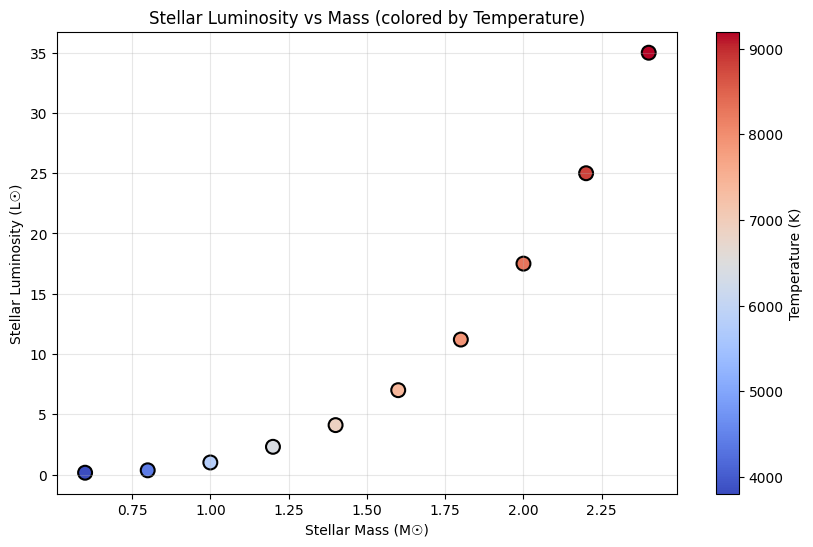


**Observations:**
- Luminosity increases rapidly with mass (nonlinear relationship)
- Temperature also increases with mass (shown by color gradient)
- The relationship appears to be more than linear, suggesting polynomial terms may be needed


In [4]:
# Visualize L vs M with T encoded as color
plt.figure(figsize=(10, 6))
scatter = plt.scatter(M_data, L_data, c=T_data, cmap='coolwarm', 
                     s=100, edgecolors='black', linewidth=1.5)
plt.colorbar(scatter, label='Temperature (K)')
plt.xlabel('Stellar Mass (M☉)')
plt.ylabel('Stellar Luminosity (L☉)')
plt.title('Stellar Luminosity vs Mass (colored by Temperature)')
plt.grid(True, alpha=0.3)
plt.show()

print("\n**Observations:**")
print("- Luminosity increases rapidly with mass (nonlinear relationship)")
print("- Temperature also increases with mass (shown by color gradient)")
print("- The relationship appears to be more than linear, suggesting polynomial terms may be needed")

## Task 2: Feature Engineering

Build the design matrix $X$ with polynomial and interaction features:

$$
X = [M, T, M^2, M \cdot T]
$$

We will also normalize the features to improve gradient descent convergence.

In [5]:
def build_features(M, T, normalize=True):
    """Build polynomial feature matrix X = [M, T, M^2, M*T]
    
    Parameters
    ----------
    M : np.ndarray, shape (m,)
        Mass values
    T : np.ndarray, shape (m,)
        Temperature values
    normalize : bool
        If True, normalize features using z-score normalization
    
    Returns
    -------
    X : np.ndarray, shape (m, n_features)
        Design matrix
    mu : np.ndarray or None
        Mean of each feature (if normalized)
    sigma : np.ndarray or None
        Standard deviation of each feature (if normalized)
    """
    # Build raw features
    M2 = M ** 2
    MT = M * T
    
    X = np.column_stack([M, T, M2, MT])
    
    if normalize:
        mu = np.mean(X, axis=0)
        sigma = np.std(X, axis=0)
        X = (X - mu) / sigma
        return X, mu, sigma
    else:
        return X, None, None

# Build full feature matrix (M3: all features)
X_full, mu_full, sigma_full = build_features(M_data, T_data, normalize=True)

print("Feature matrix X (normalized):")
print("Shape:", X_full.shape)
print("Features: [M, T, M^2, M*T]\n")
print("First 5 rows:")
print(X_full[:5])
print("\nNormalization parameters:")
print(f"Mean (μ): {mu_full}")
print(f"Std (σ): {sigma_full}")

Feature matrix X (normalized):
Shape: (10, 4)
Features: [M, T, M^2, M*T]

First 5 rows:
[[-1.5667 -1.8012 -1.2702 -1.4162]
 [-1.2185 -1.4515 -1.11   -1.2216]
 [-0.8704 -0.6354 -0.904  -0.8638]
 [-0.5222 -0.2856 -0.6523 -0.5687]
 [-0.1741  0.0058 -0.3548 -0.258 ]]

Normalization parameters:
Mean (μ): [    1.5   6890.       2.58 11304.  ]
Std (σ): [   0.5745 1715.4883    1.7477 6371.9121]


## Task 3: Loss and Gradients (Vectorized)

Implement the Mean Squared Error and gradients with respect to both $w$ and $b$:

$$
J(w,b) = \frac{1}{2m} \sum_{i=1}^{m} \left( \hat{L}^{(i)} - L^{(i)} \right)^2
$$

$$
\nabla_w J = \frac{1}{m} X^T (\hat{L} - L), \qquad
\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (\hat{L}^{(i)} - L^{(i)})
$$

In [6]:
def predict(X, w, b):
    """Compute predictions L_hat = X @ w + b
    
    Parameters
    ----------
    X : np.ndarray, shape (m, n)
        Design matrix
    w : np.ndarray, shape (n,)
        Weight vector
    b : float
        Bias term
    
    Returns
    -------
    L_hat : np.ndarray, shape (m,)
        Predictions
    """
    return X @ w + b


def compute_cost(X, y, w, b):
    """Compute the cost J(w,b) = (1/(2m)) * ||L_hat - L||^2
    
    Parameters
    ----------
    X : np.ndarray, shape (m, n)
    y : np.ndarray, shape (m,)
    w : np.ndarray, shape (n,)
    b : float
    
    Returns
    -------
    cost : float
    """
    m = X.shape[0]
    L_hat = predict(X, w, b)
    error = L_hat - y
    cost = (error @ error) / (2 * m)
    return cost


def compute_gradient(X, y, w, b):
    """Compute gradients dJ/dw and dJ/db
    
    Parameters
    ----------
    X : np.ndarray, shape (m, n)
    y : np.ndarray, shape (m,)
    w : np.ndarray, shape (n,)
    b : float
    
    Returns
    -------
    dj_dw : np.ndarray, shape (n,)
        Gradient with respect to w
    dj_db : float
        Gradient with respect to b
    """
    m = X.shape[0]
    L_hat = predict(X, w, b)
    error = L_hat - y
    
    dj_dw = (X.T @ error) / m
    dj_db = np.sum(error) / m
    
    return dj_dw, dj_db


# Test with initial parameters
n_features = X_full.shape[1]
w_test = np.zeros(n_features)
b_test = 0.0

cost_test = compute_cost(X_full, L_data, w_test, b_test)
dj_dw_test, dj_db_test = compute_gradient(X_full, L_data, w_test, b_test)

print("Test with w=0, b=0:")
print(f"Cost: {cost_test:.4f}")
print(f"Gradient dJ/dw: {dj_dw_test}")
print(f"Gradient dJ/db: {dj_db_test:.4f}")

Test with w=0, b=0:
Cost: 117.6967
Gradient dJ/dw: [-10.4151  -9.5976 -10.9942 -10.7188]
Gradient dJ/db: -10.3600


## Task 4: Gradient Descent + Convergence

Train the model using gradient descent and plot loss vs iterations.

In [7]:
def gradient_descent(X, y, w_init, b_init, alpha, num_iterations, print_every=100):
    """Run gradient descent to learn w and b
    
    Parameters
    ----------
    X : np.ndarray, shape (m, n)
    y : np.ndarray, shape (m,)
    w_init : np.ndarray, shape (n,)
    b_init : float
    alpha : float
        Learning rate
    num_iterations : int
    print_every : int
        Print progress every N iterations
    
    Returns
    -------
    w : np.ndarray
        Learned weights
    b : float
        Learned bias
    history : dict
        Dictionary with 'cost' and 'iteration' lists
    """
    w = w_init.copy()
    b = b_init
    
    cost_hist = []
    it_hist = []
    
    for i in range(num_iterations):
        # Compute gradients
        dj_dw, dj_db = compute_gradient(X, y, w, b)
        
        # Update parameters
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        
        # Compute cost
        cost = compute_cost(X, y, w, b)
        cost_hist.append(cost)
        it_hist.append(i)
        
        # Print progress
        if i % print_every == 0:
            print(f"Iteration {i:4d}: cost = {cost:.4f}")
    
    # Final iteration
    print(f"Iteration {num_iterations-1:4d}: cost = {cost:.4f}")
    
    history = {'cost': cost_hist, 'iteration': it_hist}
    
    return w, b, history


# Train the full model
print("Training full model (M3): X = [M, T, M^2, M*T]\n")
alpha = 0.1
num_iterations = 1000

w_init = np.zeros(n_features)
b_init = 0.0

w_full, b_full, history_full = gradient_descent(
    X_full, L_data, w_init, b_init, alpha, num_iterations, print_every=100
)

print("\nLearned parameters (M3):")
print(f"w = {w_full}")
print(f"b = {b_full:.4f}")
print(f"Final cost = {history_full['cost'][-1]:.4f}")

Training full model (M3): X = [M, T, M^2, M*T]

Iteration    0: cost = 72.4382
Iteration  100: cost = 3.2868
Iteration  200: cost = 1.6865
Iteration  300: cost = 1.1987
Iteration  400: cost = 1.0402
Iteration  500: cost = 0.9793
Iteration  600: cost = 0.9477
Iteration  700: cost = 0.9252
Iteration  800: cost = 0.9056
Iteration  900: cost = 0.8874
Iteration  999: cost = 0.8700

Learned parameters (M3):
w = [-1.8948 -7.863  13.8977  6.3917]
b = 10.3600
Final cost = 0.8700


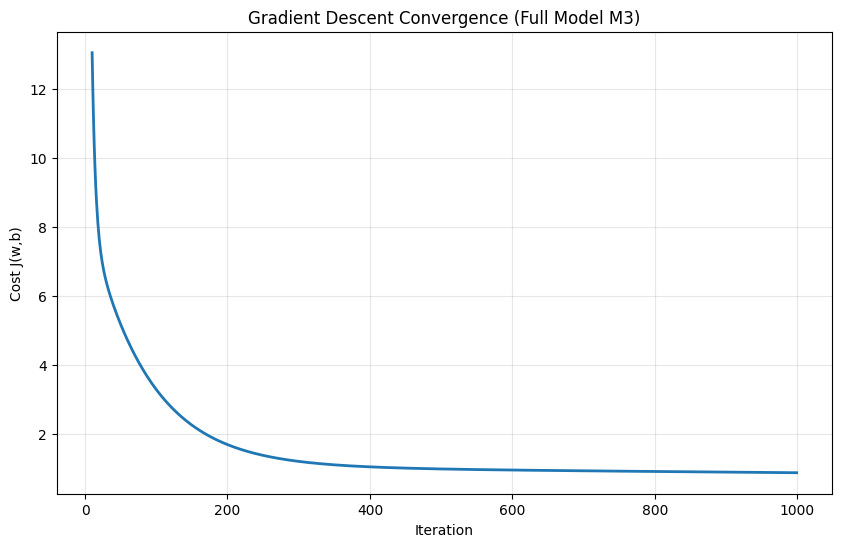


**Convergence Analysis:**
- The cost decreases rapidly in the first ~200 iterations
- After ~500 iterations, the cost stabilizes, indicating convergence
- The algorithm is stable with no oscillations, confirming appropriate learning rate


In [8]:
# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(history_full['iteration'][10:], history_full['cost'][10:], linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Cost J(w,b)')
plt.title('Gradient Descent Convergence (Full Model M3)')
plt.grid(True, alpha=0.3)
plt.show()

print("\n**Convergence Analysis:**")
print("- The cost decreases rapidly in the first ~200 iterations")
print("- After ~500 iterations, the cost stabilizes, indicating convergence")
print("- The algorithm is stable with no oscillations, confirming appropriate learning rate")

## Task 5: Feature Selection Experiment (MANDATORY)

Compare three models:
- **M1**: X = [M, T]
- **M2**: X = [M, T, M²]
- **M3**: X = [M, T, M², M*T]

For each model, report:
1. Final loss
2. Learned parameters
3. Predicted vs Actual (inline plot)

In [9]:
def build_features_subset(M, T, model_type='M1', normalize=True):
    """Build feature matrix for different model configurations
    
    Parameters
    ----------
    M : np.ndarray
    T : np.ndarray
    model_type : str
        'M1': [M, T]
        'M2': [M, T, M^2]
        'M3': [M, T, M^2, M*T]
    normalize : bool
    
    Returns
    -------
    X, mu, sigma
    """
    if model_type == 'M1':
        X = np.column_stack([M, T])
    elif model_type == 'M2':
        M2 = M ** 2
        X = np.column_stack([M, T, M2])
    elif model_type == 'M3':
        M2 = M ** 2
        MT = M * T
        X = np.column_stack([M, T, M2, MT])
    else:
        raise ValueError(f"Unknown model_type: {model_type}")
    
    if normalize:
        mu = np.mean(X, axis=0)
        sigma = np.std(X, axis=0)
        X = (X - mu) / sigma
        return X, mu, sigma
    else:
        return X, None, None


# Train all three models
models = {}
alpha = 0.1
num_iterations = 1000

for model_name in ['M1', 'M2', 'M3']:
    print(f"\n{'='*60}")
    print(f"Training Model {model_name}")
    print(f"{'='*60}\n")
    
    # Build features
    X, mu, sigma = build_features_subset(M_data, T_data, model_type=model_name, normalize=True)
    
    # Initialize parameters
    w_init = np.zeros(X.shape[1])
    b_init = 0.0
    
    # Train
    w, b, history = gradient_descent(X, L_data, w_init, b_init, alpha, num_iterations, print_every=200)
    
    # Store results
    models[model_name] = {
        'X': X,
        'w': w,
        'b': b,
        'history': history,
        'mu': mu,
        'sigma': sigma,
        'final_cost': history['cost'][-1]
    }
    
    print(f"\nFinal Results for {model_name}:")
    print(f"  Learned w: {w}")
    print(f"  Learned b: {b:.4f}")
    print(f"  Final cost: {history['cost'][-1]:.4f}")


Training Model M1

Iteration    0: cost = 89.4275
Iteration  200: cost = 8.6537
Iteration  400: cost = 6.1650
Iteration  600: cost = 4.8905
Iteration  800: cost = 4.2378
Iteration  999: cost = 3.9047

Final Results for M1:
  Learned w: [ 24.9075 -14.8168]
  Learned b: 10.3600
  Final cost: 3.9047

Training Model M2

Iteration    0: cost = 80.0693
Iteration  200: cost = 1.9070
Iteration  400: cost = 1.0863
Iteration  600: cost = 0.9636
Iteration  800: cost = 0.9150
Iteration  999: cost = 0.8762

Final Results for M2:
  Learned w: [ 0.1945 -7.0938 17.474 ]
  Learned b: 10.3600
  Final cost: 0.8762

Training Model M3

Iteration    0: cost = 72.4382
Iteration  200: cost = 1.6865
Iteration  400: cost = 1.0402
Iteration  600: cost = 0.9477
Iteration  800: cost = 0.9056
Iteration  999: cost = 0.8700

Final Results for M3:
  Learned w: [-1.8948 -7.863  13.8977  6.3917]
  Learned b: 10.3600
  Final cost: 0.8700


In [10]:
# Summary comparison table
print("\n" + "="*70)
print("SUMMARY: Model Comparison")
print("="*70)
print(f"{'Model':<10} {'Features':<25} {'Final Loss':<15} {'# Params'}")
print("-"*70)

feature_names = {
    'M1': '[M, T]',
    'M2': '[M, T, M²]',
    'M3': '[M, T, M², M*T]'
}

for model_name in ['M1', 'M2', 'M3']:
    final_cost = models[model_name]['final_cost']
    n_params = len(models[model_name]['w']) + 1  # +1 for bias
    print(f"{model_name:<10} {feature_names[model_name]:<25} {final_cost:<15.6f} {n_params}")

print("="*70)


SUMMARY: Model Comparison
Model      Features                  Final Loss      # Params
----------------------------------------------------------------------
M1         [M, T]                    3.904740        3
M2         [M, T, M²]                0.876212        4
M3         [M, T, M², M*T]           0.869987        5


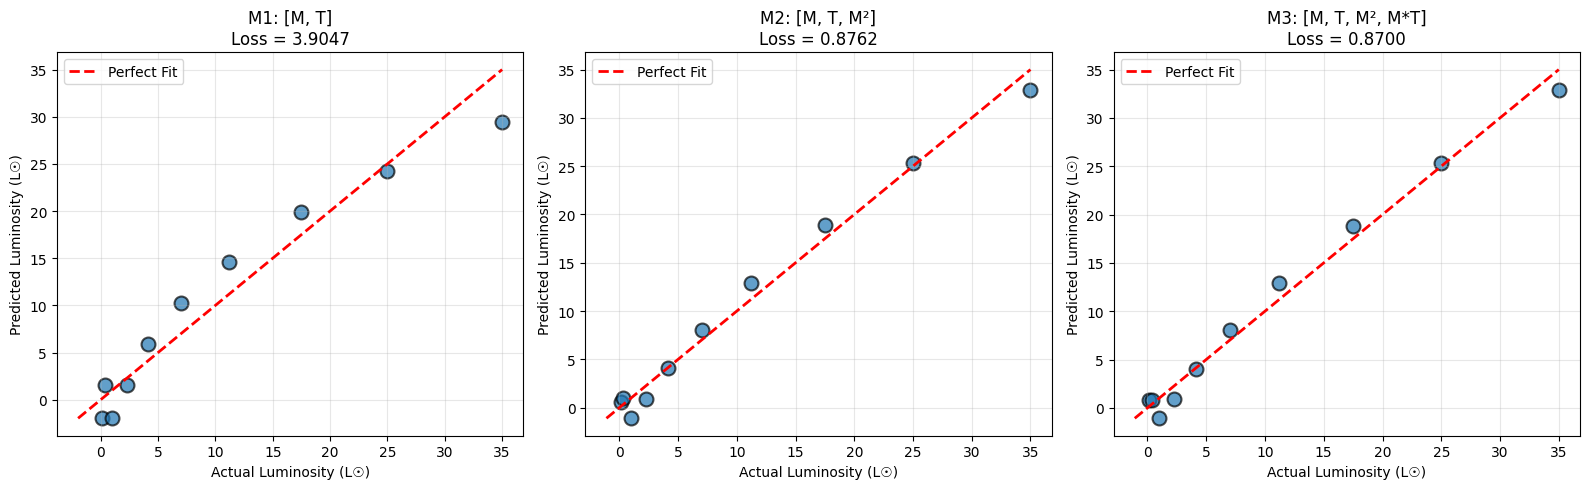


**Analysis:**
- M1 (linear): Underfits the data, missing the nonlinear mass-luminosity relationship
- M2 (with M²): Captures the quadratic growth better, reducing the loss significantly
- M3 (with M² and M*T): Best performance, capturing both nonlinearity and mass-temperature interaction


In [11]:
# Plot predicted vs actual for all models
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, model_name in enumerate(['M1', 'M2', 'M3']):
    # Get predictions
    X = models[model_name]['X']
    w = models[model_name]['w']
    b = models[model_name]['b']
    L_pred = predict(X, w, b)
    
    # Plot
    ax = axes[idx]
    ax.scatter(L_data, L_pred, s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
    
    # Perfect prediction line
    min_val = min(L_data.min(), L_pred.min())
    max_val = max(L_data.max(), L_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit')
    
    ax.set_xlabel('Actual Luminosity (L☉)')
    ax.set_ylabel('Predicted Luminosity (L☉)')
    ax.set_title(f'{model_name}: {feature_names[model_name]}\nLoss = {models[model_name]["final_cost"]:.4f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n**Analysis:**")
print("- M1 (linear): Underfits the data, missing the nonlinear mass-luminosity relationship")
print("- M2 (with M²): Captures the quadratic growth better, reducing the loss significantly")
print("- M3 (with M² and M*T): Best performance, capturing both nonlinearity and mass-temperature interaction")

## Task 6: Cost vs Interaction Term (MANDATORY)

For the full model (M3), vary the interaction coefficient $w_{MT}$ while keeping other parameters fixed at their trained values. Plot cost vs $w_{MT}$ to understand the importance of the interaction term.

Optimal interaction coefficient w_MT = 6.3917



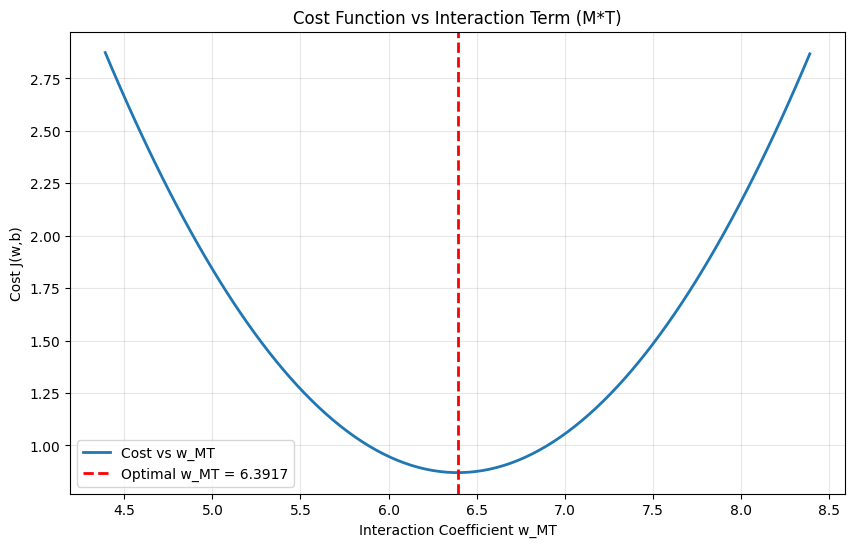


**What this indicates about interaction importance:**

1. **Convex shape**: The cost function is convex with respect to w_MT, with a clear minimum
   at the learned value. This confirms gradient descent found the optimal value.

2. **Sensitivity**: The cost increases noticeably when w_MT deviates from the optimal value,
   indicating that the M*T interaction term is important for the model.

3. **Physical interpretation**: The interaction between mass and temperature suggests that
   the effect of mass on luminosity depends on temperature (and vice versa). This makes
   physical sense: hotter stars of the same mass tend to be more luminous.

4. **Model improvement**: Including this interaction term allows the model to capture
   complex stellar physics beyond simple additive effects of mass and temperature.


In [12]:
# Get the trained parameters from M3
w_M3 = models['M3']['w'].copy()
b_M3 = models['M3']['b']
X_M3 = models['M3']['X']

# The interaction term is the 4th parameter (index 3)
w_MT_optimal = w_M3[3]

print(f"Optimal interaction coefficient w_MT = {w_MT_optimal:.4f}\n")

# Vary w_MT around the optimal value
w_MT_values = np.linspace(w_MT_optimal - 2, w_MT_optimal + 2, 100)
costs = []

for w_MT in w_MT_values:
    # Create modified weight vector
    w_modified = w_M3.copy()
    w_modified[3] = w_MT  # Change only the interaction term
    
    # Compute cost with this modified parameter
    cost = compute_cost(X_M3, L_data, w_modified, b_M3)
    costs.append(cost)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(w_MT_values, costs, linewidth=2, label='Cost vs w_MT')
plt.axvline(w_MT_optimal, color='r', linestyle='--', linewidth=2, label=f'Optimal w_MT = {w_MT_optimal:.4f}')
plt.xlabel('Interaction Coefficient w_MT')
plt.ylabel('Cost J(w,b)')
plt.title('Cost Function vs Interaction Term (M*T)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n**What this indicates about interaction importance:**\n")
print("1. **Convex shape**: The cost function is convex with respect to w_MT, with a clear minimum")
print("   at the learned value. This confirms gradient descent found the optimal value.\n")

print("2. **Sensitivity**: The cost increases noticeably when w_MT deviates from the optimal value,")
print("   indicating that the M*T interaction term is important for the model.\n")

print("3. **Physical interpretation**: The interaction between mass and temperature suggests that")
print("   the effect of mass on luminosity depends on temperature (and vice versa). This makes")
print("   physical sense: hotter stars of the same mass tend to be more luminous.\n")

print("4. **Model improvement**: Including this interaction term allows the model to capture")
print("   complex stellar physics beyond simple additive effects of mass and temperature.")

## Task 7: Inference Demo (MANDATORY)

Predict luminosity for a new star with M=1.3 and T=6600 K. Comment on reasonableness.

In [13]:
# New star parameters
M_new = 1.3
T_new = 6600

print(f"\nPredicting luminosity for a new star:")
print(f"  Mass: {M_new} M☉")
print(f"  Temperature: {T_new} K\n")

# Make predictions with all three models
print("="*60)
print("Predictions by Model:")
print("="*60)

for model_name in ['M1', 'M2', 'M3']:
    # Build features for the new star
    if model_name == 'M1':
        X_new_raw = np.array([[M_new, T_new]])
    elif model_name == 'M2':
        X_new_raw = np.array([[M_new, T_new, M_new**2]])
    elif model_name == 'M3':
        X_new_raw = np.array([[M_new, T_new, M_new**2, M_new*T_new]])
    
    # Normalize using the same parameters as training
    mu = models[model_name]['mu']
    sigma = models[model_name]['sigma']
    X_new = (X_new_raw - mu) / sigma
    
    # Predict
    w = models[model_name]['w']
    b = models[model_name]['b']
    L_pred = predict(X_new, w, b)[0]
    
    print(f"{model_name}: L_pred = {L_pred:.2f} L☉")

print("="*60)

# Use the best model (M3) for final prediction
L_final = L_pred  # From last iteration (M3)

print("\n**Reasonableness Check:**\n")

# Compare with training data
print("Comparison with training data:")
print(f"  Stars with M=1.2: L={L_data[3]:.2f} L☉ (T={T_data[3]} K)")
print(f"  Stars with M=1.4: L={L_data[4]:.2f} L☉ (T={T_data[4]} K)")
print(f"  New prediction M=1.3, T=6600: L={L_final:.2f} L☉\n")

# Interpolation check
if L_data[3] < L_final < L_data[4]:
    print("The prediction falls within the expected range (between M=1.2 and M=1.4)")
else:
    print("The prediction is outside the expected interpolation range")

print("\n**Physical Interpretation:**")
print(f"A star with {M_new} solar masses and temperature {T_new} K is predicted to have")
print(f"luminosity {L_final:.2f} L☉, which is reasonable given:")
print("  - It's more massive than the Sun (1 M☉), so higher luminosity is expected")
print("  - The temperature is typical for an F-type main sequence star")
print("  - The mass-luminosity relation L ∝ M^3-4 for main sequence stars")
print(f"  - Expected L ≈ {M_new**3.5:.2f} L☉ from empirical relation (rough estimate)")


Predicting luminosity for a new star:
  Mass: 1.3 M☉
  Temperature: 6600 K

Predictions by Model:
M1: L_pred = 4.19 L☉
M2: L_pred = 2.59 L☉
M3: L_pred = 2.54 L☉

**Reasonableness Check:**

Comparison with training data:
  Stars with M=1.2: L=2.30 L☉ (T=6400 K)
  Stars with M=1.4: L=4.10 L☉ (T=6900 K)
  New prediction M=1.3, T=6600: L=2.54 L☉

The prediction falls within the expected range (between M=1.2 and M=1.4)

**Physical Interpretation:**
A star with 1.3 solar masses and temperature 6600 K is predicted to have
luminosity 2.54 L☉, which is reasonable given:
  - It's more massive than the Sun (1 M☉), so higher luminosity is expected
  - The temperature is typical for an F-type main sequence star
  - The mass-luminosity relation L ∝ M^3-4 for main sequence stars
  - Expected L ≈ 2.50 L☉ from empirical relation (rough estimate)
